### Paso 1. Librerías

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
pd.options.display.float_format = '{:,.0f}'.format

### Paso 2. Carga y división del conjunto de datos

In [2]:
# cargamos los datos
data = np.load('proyecto_training_data.npy')

In [3]:
# los transformamos en un dataframe con columnas nombradas de acuerdo al Data fields.txt
df_data = pd.DataFrame(data,columns=['SalePrice','OveralQuad','1stFlrSF',
                                     'TotRmsAbvGrd','YearBuilt','LotFrontage']
                      )
print(f"Cantidad de registros: {df_data.shape[0]}")
print(f"Cantidad de columnas: {df_data.shape[1]}\n")
df_data.head()

Cantidad de registros: 1460
Cantidad de columnas: 6



,SalePrice,OveralQuad,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
0,"208,500",7,856,8,"2,003",65
1,"181,500",6,"1,262",6,"1,976",80
2,"223,500",7,920,6,"2,001",68
3,"140,000",7,961,7,"1,915",60
4,"250,000",8,"1,145",9,"2,000",84


In [4]:
# se seleccionan aleatoriamente 1168 índices (el 80%) del data set para el set de entrenamiento
training_index = []
cant_reg = data.shape[0]
while len(training_index) < int(cant_reg*0.8):
    num = random.randint(0,cant_reg - 1)
    # No se toman índices repetidos
    if num in training_index:
        continue
    else:
        training_index.append(num)

In [5]:
# para el set de prueba se seleccionan los demás índices que no se tomaron para el
# set de entrenamiento. Se hace una diferencia de conjuntos.
total_index = [i for i in range(0,cant_reg-1)]
test_index = list(set(total_index).difference(set(training_index)))

In [6]:
# se forman los set de entrenamiento y prueba con los índices obtenidos anteriormente
training_data = data[np.array(training_index)]
test_data = data[np.array(test_index)]

### Paso 3. Análisis explotario de variables

In [7]:
for col in df_data.columns:
    print(f'Variable {col}\n{30*"-"}')
    mean_price = df_data[col].mean() 
    print(f'{mean_price = :}')
    min_price = df_data[col].min() 
    print(f'{min_price = :}')
    max_price = df_data[col].max() 
    print(f'{max_price = :}')
    peak_price = max_price - min_price 
    print(f'{peak_price = :}')
    std_price = df_data[col].std() 
    print(f'{std_price = :}')
    print(f"{30*'-'}\n")

Variable SalePrice
------------------------------
mean_price = 180921.19589041095
min_price = 34900.0
max_price = 755000.0
peak_price = 720100.0
std_price = 79442.50288288663
------------------------------

Variable OveralQuad
------------------------------
mean_price = 6.0993150684931505
min_price = 1.0
max_price = 10.0
peak_price = 9.0
std_price = 1.3829965467415923
------------------------------

Variable 1stFlrSF
------------------------------
mean_price = 1162.626712328767
min_price = 334.0
max_price = 4692.0
peak_price = 4358.0
std_price = 386.5877380410738
------------------------------

Variable TotRmsAbvGrd
------------------------------
mean_price = 6.517808219178082
min_price = 2.0
max_price = 14.0
peak_price = 12.0
std_price = 1.625393290584064
------------------------------

Variable YearBuilt
------------------------------
mean_price = 1971.267808219178
min_price = 1872.0
max_price = 2010.0
peak_price = 138.0
std_price = 30.202904042525265
------------------------------



### Paso 4. Análisis gráfico por variable

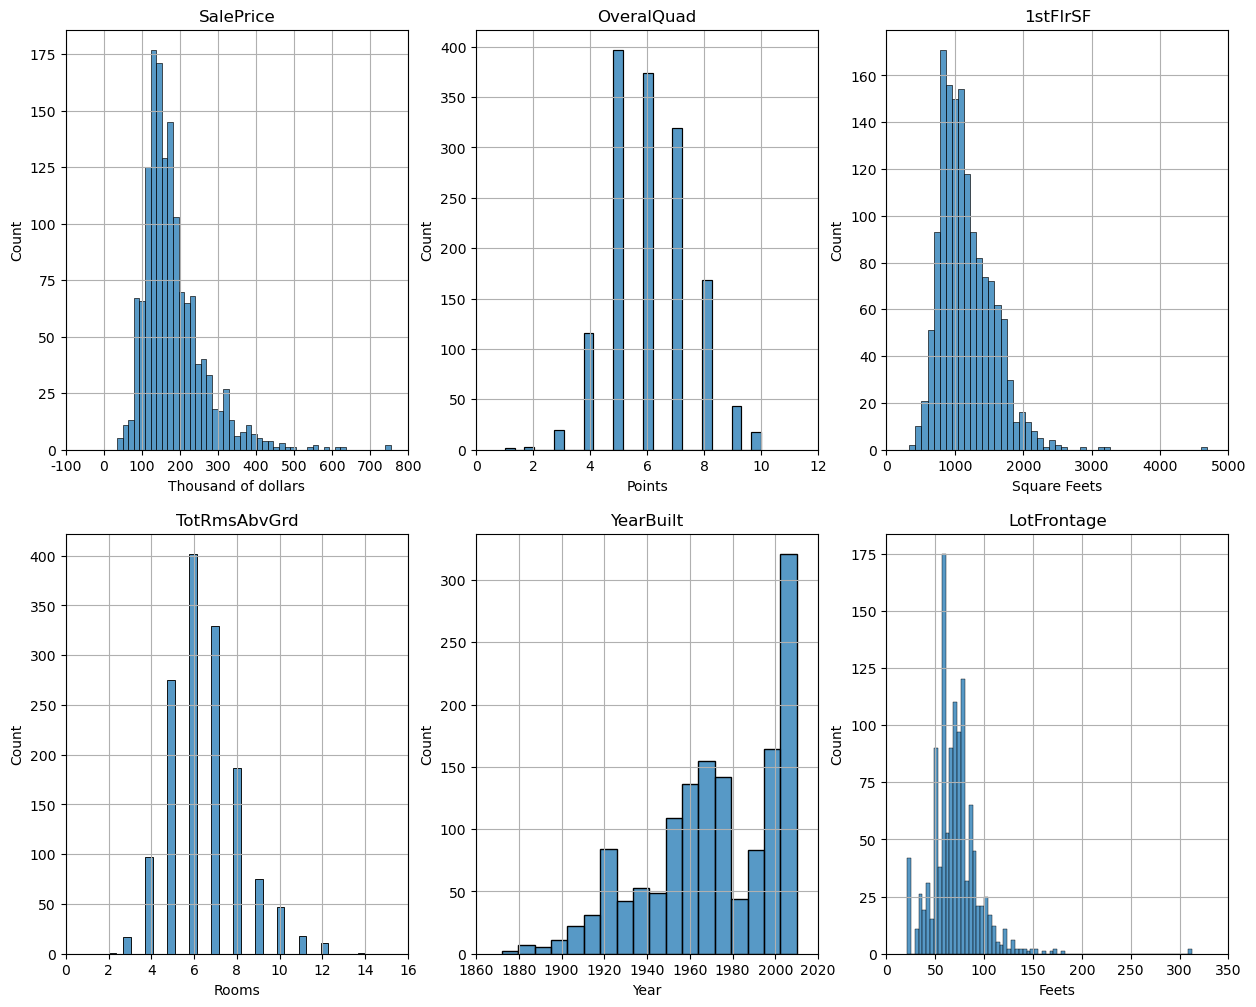

In [8]:
nxm = len(df_data.columns)
n = 2
m = 3
units = ['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets']
fig, ax =  plt.subplots(n,m, figsize=(15,12))
for i, col in enumerate(df_data.columns):
    graf = sns.histplot(data=df_data[col], ax=ax[i//m,i%m])
    graf.set_title(col)
    xtick = graf.get_xticks() if col != 'SalePrice' else graf.get_xticks()/1e3
    xticklabel = [f"{int(val)}" for val in graf.get_xticks()] if col != 'SalePrice' else [f"{int(val)}" for val in graf.get_xticks()/1e3]
    graf.set_xticks(graf.get_xticks())
    graf.set_xticklabels(xticklabel)
    graf.set_xlabel(units[i])
    graf.grid()
plt.show()

### Paso 5. Correlación

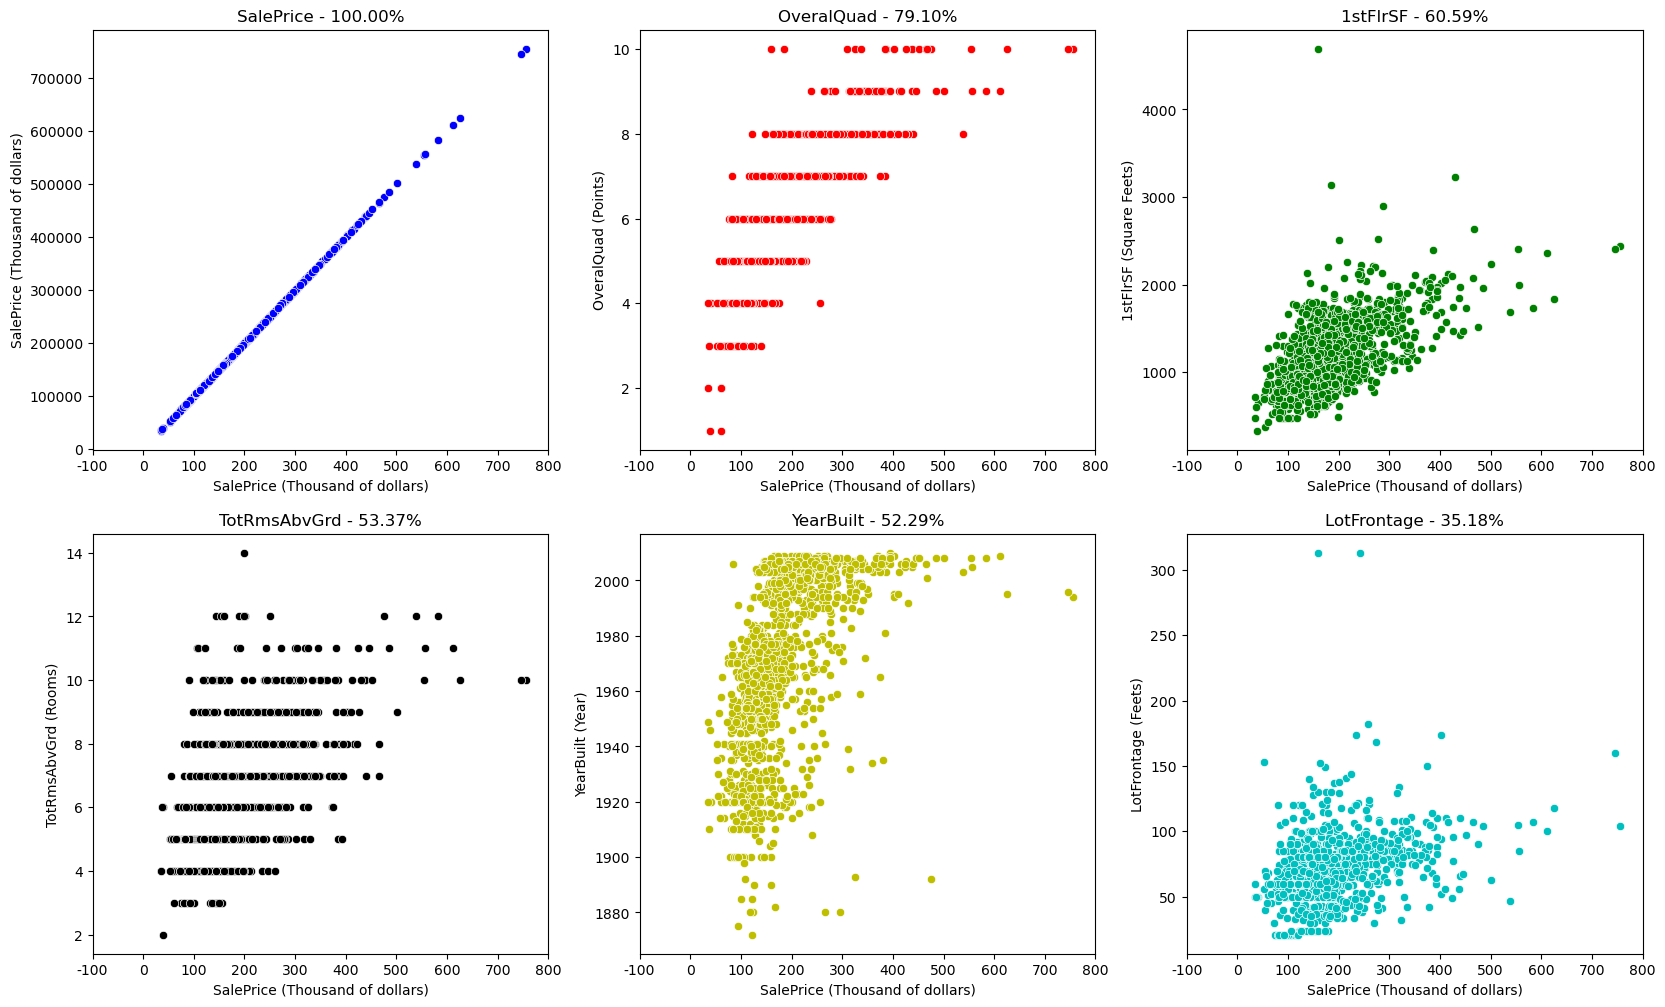

In [9]:
fig, ax =  plt.subplots(n,m, figsize=(20,12))
colors = ['b','r','g','k','y','c']
units = ['Thousand of dollars','Points','Square Feets','Rooms','Year','Feets']
for i, col in enumerate(df_data.columns):
    correlacion = df_data.SalePrice.corr(df_data[col])
    scat = sns.scatterplot(x=df_data.SalePrice,y=df_data[col], ax=ax[i//m,i%m], color=colors[i])
    xtick = scat.get_xticks()/1e3
    xticklabel = [f"{int(val)}" for val in scat.get_xticks()/1e3]
    scat.set_xticks(scat.get_xticks())
    scat.set_xticklabels(xticklabel)
    scat.set_title(f"{col} - {correlacion*100:.2f}%")
    scat.set_xlabel("SalePrice (Thousand of dollars)")
    scat.set_ylabel(f"{col} ({units[i]})")
plt.show()

Con base en el anterior análisis, se escogen los campos ***OveralQuad*** y ***1stFlrSF*** para realizar los modelos,
ya que presentan la mayor correlación con la variable de salida ***SalePice***, lo que significa que el material y el acabado
de la casa, y  el área del primer nivel influencian más en el precio de la casa.

### Paso 6. Función para entrenar modelo

In [168]:
def entrenar_modelo(x, y, epochs, imprimir_error_cada, alpha):
    iters = dict()
    vec_err = []
    ones = np.ones_like(x.reshape(-1,1))
    A = np.hstack([x.reshape(-1,1), ones])
    b0 = 1000.0
    b1 = 500.0#1.0
    betas = np.array([b1,b0])
    for n in range(1,epochs+1):
        y_pred = np.matmul(A, betas)
        err = ((y - y_pred)**2).sum()/(2*len(y))
        vec_err.append(err)
        grad = np.matmul((y_pred - y)/len(y), A)
        betas -= alpha*grad
        iters[n] = betas
        if n%imprimir_error_cada == 0:
            print(f'Iteración {n}: Error {err}')
    return iters, np.array(vec_err)

In [93]:
y_train_ov = training_data[:,0]
x_train_ov = training_data[:,1]

In [110]:
entrenar_modelo(x_train_ov,y_train_ov,50000,1000,6e-3) #Error 1223799089.3351064

Iteración 1000: Error 1370537751.101378
Iteración 2000: Error 1306508717.0209792
Iteración 3000: Error 1270418585.7213376
Iteración 4000: Error 1250076289.5125604
Iteración 5000: Error 1238610301.439257
Iteración 6000: Error 1232147467.4923005
Iteración 7000: Error 1228504674.3584769
Iteración 8000: Error 1226451404.5507197
Iteración 9000: Error 1225294073.6926208
Iteración 10000: Error 1224641741.1496449
Iteración 11000: Error 1224274052.2181292
Iteración 12000: Error 1224066803.3972402
Iteración 13000: Error 1223949987.0612605
Iteración 14000: Error 1223884143.2301924
Iteración 15000: Error 1223847030.1838589
Iteración 16000: Error 1223826111.3189354
Iteración 17000: Error 1223814320.3464093
Iteración 18000: Error 1223807674.3341315
Iteración 19000: Error 1223803928.2920558
Iteración 20000: Error 1223801816.825714
Iteración 21000: Error 1223800626.692228
Iteración 22000: Error 1223799955.870399
Iteración 23000: Error 1223799577.7599337
Iteración 24000: Error 1223799364.6369877
Iterac

In [51]:
y_train_fl = training_data[:,0]
x_train_fl = training_data[:,2]

In [181]:
entrenar_modelo(x_train_fl,y_train_fl,10000,1000,1.3e-6)

Iteración 1000: Error 2153971235.941293
Iteración 2000: Error 2152737006.526478
Iteración 3000: Error 2152717749.73635
Iteración 4000: Error 2152698513.6776104
Iteración 5000: Error 2152679282.722554
Iteración 6000: Error 2152660056.8696256
Iteración 7000: Error 2152640836.11747
Iteración 8000: Error 2152621620.464736
Iteración 9000: Error 2152602409.9100685
Iteración 10000: Error 2152583204.4521165


({1: array([ 151.00200523, 1049.72993578]),
  2: array([ 151.00200523, 1049.72993578]),
  3: array([ 151.00200523, 1049.72993578]),
  4: array([ 151.00200523, 1049.72993578]),
  5: array([ 151.00200523, 1049.72993578]),
  6: array([ 151.00200523, 1049.72993578]),
  7: array([ 151.00200523, 1049.72993578]),
  8: array([ 151.00200523, 1049.72993578]),
  9: array([ 151.00200523, 1049.72993578]),
  10: array([ 151.00200523, 1049.72993578]),
  11: array([ 151.00200523, 1049.72993578]),
  12: array([ 151.00200523, 1049.72993578]),
  13: array([ 151.00200523, 1049.72993578]),
  14: array([ 151.00200523, 1049.72993578]),
  15: array([ 151.00200523, 1049.72993578]),
  16: array([ 151.00200523, 1049.72993578]),
  17: array([ 151.00200523, 1049.72993578]),
  18: array([ 151.00200523, 1049.72993578]),
  19: array([ 151.00200523, 1049.72993578]),
  20: array([ 151.00200523, 1049.72993578]),
  21: array([ 151.00200523, 1049.72993578]),
  22: array([ 151.00200523, 1049.72993578]),
  23: array([ 151.0

In [ ]:
2099467740.537363